In [1]:
1+1

2

In [ ]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
import re
import os, json

from textwrap import dedent
from pprint import pprint

import warnings
warnings.filterwarnings("ignore")

In [5]:
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma

embeddings_model = OpenAIEmbeddings(
    model="text-embedding-3-small",
)


In [ ]:
# 벡터 저장소 로드

from langchain_core.tools import tool
from typing import List

menu_db = Chroma(
    embedding_function=embeddings_model,
    collection_name="restaurant_menu",
    persist_directory="./chroma_db",
)


@tool
def search_menu(query: str) -> List[str]:
    """
   레스토랑 메뉴에서 정보를 검색합니다. 
    """
    docs = menu_db.similarity_search(query, k=2)
    
    formatted_docs = "\n--\n".join([
        f'<Document href="{doc.metadata["source"]}">\n{doc.page_content}\n</Document>'
        for doc in docs
            
    ])
    
    if len(formatted_docs) > 0:
        return formatted_docs
    
    return "관련 정보를 찾을 수 없습니다."
   

In [13]:
from langchain_community.tools import TavilySearchResults

#툴 만들기
@tool
def search_web(query: str) -> str:      #쿼리가 들어오면 문자열로 답
    """
    데이터 베이스에 존제하지 않는 정보 또는 최신 정보를 인터넷으로 검색합니다.
    """
    
    tavily_search = TavilySearchResults(max_results=3)
    docs = tavily_search.invoke(query)
    
    # print(docs)
    formatted_docs = "\n\n--\n\n".join(
        [
            f"<Document href='{doc['url']}'>\n{doc['content']}\n</Document>"
            for doc in docs            
        ])
    
    if len(formatted_docs) > 0:
        return formatted_docs
    
    return "관련 정보를 찾을 수 없습니다."



In [ ]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(       #자신의 지식을 가지고 검색
    model="gpt-4o-mini",
    streaming=True,
)

tools = [search_menu, search_web]

#툴 두개를 기반으로 검색
llm_with_tools = llm.bind_tools(tools=tools)



In [18]:
from langchain_core.messages import AIMessage, HumanMessage

#도구 호출 (어떤 툴을 호출했는지 정보)
tool_call = llm_with_tools.invoke(
    [HumanMessage("스테이크 메뉴의 가격은 얼마인가요?")]
)

print(tool_call.additional_kwargs)

{'tool_calls': [{'id': 'call_kgUa370BVsj2RWME58ET7T4l', 'function': {'arguments': '{"query":"스테이크"}', 'name': 'search_menu'}, 'type': 'function'}], 'refusal': None}


In [19]:
#도구 호출 (어떤 툴을 호출했는지 정보)
tool_call = llm_with_tools.invoke(
    [HumanMessage("langgranph는 무엇인가요?")]
)

print(tool_call.additional_kwargs)

{'tool_calls': [{'id': 'call_ywZufG40xzGwyNVTeJGa7yVs', 'function': {'arguments': '{"query":"langgranph"}', 'name': 'search_web'}, 'type': 'function'}], 'refusal': None}


In [21]:
#도구 호출 (어떤 툴을 호출했는지 정보)
tool_call = llm_with_tools.invoke(
    [HumanMessage("3+4는 얼마인가요?")]
)

print(tool_call.additional_kwargs)
print(tool_call)


{'refusal': None}
content='3 + 4는 7입니다.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 85, 'total_tokens': 95, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_62a23a81ef', 'finish_reason': 'stop', 'logprobs': None} id='run--388d8265-d335-47c6-996b-0156bb337755-0' usage_metadata={'input_tokens': 85, 'output_tokens': 10, 'total_tokens': 95}


In [ ]:
# 도구 노드 (Tool Node) : AI 모델이 요청한 (tool) 호출을 실행하는 역할을 처리하는 LangGraph 컴포넌트

from langgraph.prebuilt import ToolNode

tool_node = ToolNode(tools=tools)

In [ ]:
tool_call = llm_with_tools.invoke(
    [HumanMessage("스테이크 메뉴의 가격은 얼마인가요?")]
)
#search_menu 호출해야할것 같다는 정보 
tool_call

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_p2UzeMbPIf5cfivCk0vbq2uw', 'function': {'arguments': '{"query":"스테이크"}', 'name': 'search_menu'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 88, 'total_tokens': 104, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_62a23a81ef', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--0a3d91d1-41ec-4bb9-9182-3fc52ec0fd45-0', tool_calls=[{'name': 'search_menu', 'args': {'query': '스테이크'}, 'id': 'call_p2UzeMbPIf5cfivCk0vbq2uw', 'type': 'tool_call'}], usage_metadata={'input_tokens': 88, 'output_tokens': 16, 'total_tokens': 104})

In [27]:
results = tool_node.invoke({"messages": [tool_call]})

for result in results['messages']:
    print(result.content)
    print()

<Document href="./data/restaurant_menu.txt">
8. 안심 스테이크 샐러드
   • 가격: ₩26,000
   • 주요 식재료: 소고기 안심, 루꼴라, 체리 토마토, 발사믹 글레이즈
   • 설명: 부드러운 안심 스테이크를 얇게 슬라이스하여 신선한 루꼴라 위에 올린 메인 요리 샐러드입니다. 체리 토마토와 파마산 치즈 플레이크로 풍미를 더하고, 발사믹 글레이즈로 마무리하여 고기의 풍미를 한층 끌어올렸습니다.
</Document>
--
<Document href="./data/restaurant_menu.txt">
7. 랍스터 비스크
   • 가격: ₩28,000
   • 주요 식재료: 랍스터, 생크림, 브랜디, 파프리카
   • 설명: 랍스터 껍질과 육수로 오랜 시간 우려낸 진한 비스크 수프입니다. 생크림으로 부드러운 질감을 더하고 브랜디로 깊은 풍미를 살렸습니다. 작은 랍스터 살을 토핑으로 올려 고급스러움을 더했습니다.
</Document>



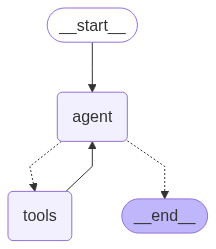

In [29]:
#ReAct Agent 구현

from IPython.display import Image, display
from langgraph.prebuilt import create_react_agent

graph = create_react_agent(
    model = llm_with_tools,        #우리가 가지고 있는 llm
    tools=tools,                    #아까 2개 툴 가진거
)

display(Image(graph.get_graph().draw_mermaid_png()))

In [31]:
inputs = {
    "messages": [
        HumanMessage("스테이크 메뉴의 가격은 얼마인가요?")
    ]
}

messages = graph.invoke(inputs)
for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

스테이크 메뉴의 가격은 얼마인가요?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_2FyrgYQ34BSDqZxtoJxCIdsn)
 Call ID: call_2FyrgYQ34BSDqZxtoJxCIdsn
  Args:
    query: 스테이크
================================= Tool Message =================================
Name: search_menu

<Document href="./data/restaurant_menu.txt">
8. 안심 스테이크 샐러드
   • 가격: ₩26,000
   • 주요 식재료: 소고기 안심, 루꼴라, 체리 토마토, 발사믹 글레이즈
   • 설명: 부드러운 안심 스테이크를 얇게 슬라이스하여 신선한 루꼴라 위에 올린 메인 요리 샐러드입니다. 체리 토마토와 파마산 치즈 플레이크로 풍미를 더하고, 발사믹 글레이즈로 마무리하여 고기의 풍미를 한층 끌어올렸습니다.
</Document>
--
<Document href="./data/restaurant_menu.txt">
7. 랍스터 비스크
   • 가격: ₩28,000
   • 주요 식재료: 랍스터, 생크림, 브랜디, 파프리카
   • 설명: 랍스터 껍질과 육수로 오랜 시간 우려낸 진한 비스크 수프입니다. 생크림으로 부드러운 질감을 더하고 브랜디로 깊은 풍미를 살렸습니다. 작은 랍스터 살을 토핑으로 올려 고급스러움을 더했습니다.
</Document>
================================== Ai Message ==================================

스테이크 메뉴의 가격은 다음과 같

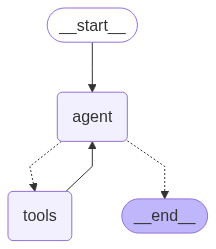

In [35]:
system_prompt = dedent("""
You are an AI assistant designed to answer human questions. 
You can use the provided tools to help generate your responses.

Follow these steps to answer questions:
    1. Carefully read and understand the question.
    2. Use the provided tools to obtain necessary information.
    3. Immediately after using a tool, cite the source using the format below.
    4. Construct an accurate and helpful answer using the tool outputs and citations.
    5. Provide the final answer when you determine it's complete.

When using tools, follow this format:
    Action: tool_name
    Action Input: input for the tool

Immediately after receiving tool output, cite the source as follows:
    [Source: tool_name | document_title/item_name | url/file_path]

For example:
    Action: search_menu
    Action Input: 스테이크
    
    (After receiving tool output)
    [Source: search_menu | 스테이크 | ./data/data.txt]
    스테이크에 대한 정보는 다음과 같습니다...

    Action: search_web
    Action Input: History of AI

    (After receiving tool output)
    [Source: search_web | AI History | https://en.wikipedia.org/wiki/History_of_artificial_intelligence]
    AI의 역사는 다음과 같이 요약됩니다...

If tool use is not necessary, answer directly.

Your final answer should be clear, concise, and directly related to the user's question. 
Ensure that every piece of factual information in your response is accompanied by a citation.

Remember: ALWAYS include these citations for all factual information, tool outputs, and referenced documents in your response. 
Do not provide any information without a corresponding citation.
""")

graph = create_react_agent(
    model = llm_with_tools,        #우리가 가지고 있는 llm
    tools=tools,                    #아까 2개 툴 가진거
    state_modifier=system_prompt,
)

display(Image(graph.get_graph().draw_mermaid_png()))

In [36]:
inputs = {
    "messages": [
        HumanMessage("스테이크 메뉴의 가격은 얼마인가요?")
    ]
}

messages = graph.invoke(inputs)
for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

스테이크 메뉴의 가격은 얼마인가요?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_NrkHyfIrZdZNNenZlesx6xrm)
 Call ID: call_NrkHyfIrZdZNNenZlesx6xrm
  Args:
    query: 스테이크
================================= Tool Message =================================
Name: search_menu

<Document href="./data/restaurant_menu.txt">
8. 안심 스테이크 샐러드
   • 가격: ₩26,000
   • 주요 식재료: 소고기 안심, 루꼴라, 체리 토마토, 발사믹 글레이즈
   • 설명: 부드러운 안심 스테이크를 얇게 슬라이스하여 신선한 루꼴라 위에 올린 메인 요리 샐러드입니다. 체리 토마토와 파마산 치즈 플레이크로 풍미를 더하고, 발사믹 글레이즈로 마무리하여 고기의 풍미를 한층 끌어올렸습니다.
</Document>
--
<Document href="./data/restaurant_menu.txt">
7. 랍스터 비스크
   • 가격: ₩28,000
   • 주요 식재료: 랍스터, 생크림, 브랜디, 파프리카
   • 설명: 랍스터 껍질과 육수로 오랜 시간 우려낸 진한 비스크 수프입니다. 생크림으로 부드러운 질감을 더하고 브랜디로 깊은 풍미를 살렸습니다. 작은 랍스터 살을 토핑으로 올려 고급스러움을 더했습니다.
</Document>
================================== Ai Message ==================================

스테이크 메뉴는 다음과 같습니다:

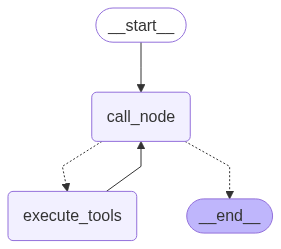

In [38]:
# create_react_agent을 하지 않고도 resoning하는 방법 => mesage state

from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

class GraphState(MessagesState):
    pass        #default 

#서로 메시지를 주고받기 위한 messages라는 스테이트가 내장되어 있음. 

#첫번째 노드 (툴 호출하는 노드가 필요함.)
def call_node(state: GraphState) -> GraphState:
    system_message = SystemMessage(content=system_prompt)
    messages = [system_message] + state["messages"]     #방금 만든것에 기본적으로 있는 messages 추가
                                    #우리가 대화하는 메시지가 들어있음. 
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}     
#결과값 넣어서 업데이트. ai메시지가 여기 들어간것임 => 이 내용 기반으로 출력해야할지, 추론 더 해야할지(툴 호출여부) 판단(분기)


def should_continue(state: GraphState):
    last_message = state['messages'][-1]        #라스트 메시지 받아서 도구 호출할지말지 정함
    if last_message.tool_calls: #툴 호출 필요하다면
        return "execute_tools" #임의로 정하는 값 
    
    return END      #필요 없으면 도구호출 없이 끝내겠다. 
    
    
builder = StateGraph(GraphState)
builder.add_node("call_node", call_node)
builder.add_node("execute_tools", ToolNode(tools=tools))        #execute_tools은 없음. 그냥 ToolNode로 호출

builder.add_edge(START, "call_node")
builder.add_conditional_edges(
    "call_node",
    should_continue,
    {
        "execute_tools" :"execute_tools",
        END: END,
    }
)
builder.add_edge("execute_tools", "call_node")

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [39]:
inputs = {
    "messages": [
        HumanMessage("스테이크 메뉴의 가격은 얼마인가요?")
    ]
}

messages = graph.invoke(inputs)
for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

스테이크 메뉴의 가격은 얼마인가요?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_eMtQreQSGWQG6MqU9wGEJvwe)
 Call ID: call_eMtQreQSGWQG6MqU9wGEJvwe
  Args:
    query: 스테이크
================================= Tool Message =================================
Name: search_menu

<Document href="./data/restaurant_menu.txt">
8. 안심 스테이크 샐러드
   • 가격: ₩26,000
   • 주요 식재료: 소고기 안심, 루꼴라, 체리 토마토, 발사믹 글레이즈
   • 설명: 부드러운 안심 스테이크를 얇게 슬라이스하여 신선한 루꼴라 위에 올린 메인 요리 샐러드입니다. 체리 토마토와 파마산 치즈 플레이크로 풍미를 더하고, 발사믹 글레이즈로 마무리하여 고기의 풍미를 한층 끌어올렸습니다.
</Document>
--
<Document href="./data/restaurant_menu.txt">
7. 랍스터 비스크
   • 가격: ₩28,000
   • 주요 식재료: 랍스터, 생크림, 브랜디, 파프리카
   • 설명: 랍스터 껍질과 육수로 오랜 시간 우려낸 진한 비스크 수프입니다. 생크림으로 부드러운 질감을 더하고 브랜디로 깊은 풍미를 살렸습니다. 작은 랍스터 살을 토핑으로 올려 고급스러움을 더했습니다.
</Document>
================================== Ai Message ==================================

스테이크 메뉴의 가격은 다음과 같

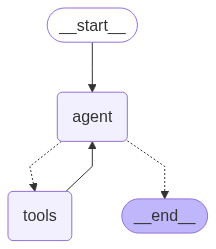

In [43]:
#위랑 같은데 tools_condition활용도 가능 
from langgraph.prebuilt import tools_condition

def call_node(state: GraphState) -> GraphState:
    system_message = SystemMessage(content=system_prompt)
    messages = [system_message] + state["messages"]    
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]} 

builder = StateGraph(GraphState)
builder.add_node("agent", call_node)        #툴콜링 메시지 불러오는 노드, 이름 같아서 바꾼거임
builder.add_node("tools",ToolNode(tools=tools))     #실행

builder.add_edge(START, "agent")
builder.add_conditional_edges(
    "agent",
    tools_condition,
)
builder.add_edge("tools", "agent")

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [45]:
inputs = {
    "messages": [
        HumanMessage("파스타에 어울리는 음료는 무엇인가요?")
    ]
}

messages = graph.invoke(inputs)
for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

파스타에 어울리는 음료는 무엇인가요?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_V6s8FoiRghk6boAuvIAG4o91)
 Call ID: call_V6s8FoiRghk6boAuvIAG4o91
  Args:
    query: 파스타 음료
================================= Tool Message =================================
Name: search_menu

<Document href="./data/restaurant_menu.txt">
6. 해산물 파스타
   • 가격: ₩24,000
   • 주요 식재료: 링귀네 파스타, 새우, 홍합, 오징어, 토마토 소스
   • 설명: 알 덴테로 삶은 링귀네 파스타에 신선한 해산물을 듬뿍 올린 메뉴입니다. 토마토 소스의 산미와 해산물의 감칠맛이 조화를 이루며, 마늘과 올리브 오일로 풍미를 더했습니다. 파슬리를 뿌려 향긋한 맛을 더합니다.
</Document>
--
<Document href="./data/restaurant_menu.txt">
4. 버섯 크림 수프
   • 가격: ₩10,000
   • 주요 식재료: 양송이버섯, 표고버섯, 생크림, 트러플 오일
   • 설명: 양송이버섯과 표고버섯을 오랜 시간 정성스레 끓여 만든 크림 수프입니다. 부드러운 텍스처와 깊은 버섯 향이 특징이며, 최상급 트러플 오일을 살짝 뿌려 고급스러운 향을 더했습니다. 파슬리를 곱게 다져 고명으로 올려 제공됩니다.
</Document>
================================== Ai Message ==================================

In [46]:
inputs = {
    "messages": [
        HumanMessage("방금 답변에 대한 출처가 있나요?")
    ]
}

messages = graph.invoke(inputs)
for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

방금 답변에 대한 출처가 있나요?
================================== Ai Message ==================================

제 답변에는 출처가 포함되어 있습니다. 모든 정보는 사용한 도구의 출력에 기반하여 제공되며, 각 정보에는 해당 출처를 명시하고 있습니다. 만약 특정 정보에 대한 출처를 알고 싶으시다면, 질문해 주시면 해당 정보와 출처를 다시 제공해 드리겠습니다.


In [ ]:
#체크포인터: 그래프의 각 단계 실행 후 상태를 저장
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

#그냥 그래프가 아니라 그래프 메모리 사용
graph_memory = builder.compile(checkpointer=memory)


In [51]:
#스레드 id

config = {"configurable": {"thread_id": "1"}}
inputs = {
    "messages": [
        HumanMessage("파스타에 어울리는 음료는 무엇?")
    ]
}

messages = graph_memory.invoke(inputs, config)
for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

파스타에 어울리는 음료는 무엇?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_17QUT5oEdjiAjU6HHoz70TH0)
 Call ID: call_17QUT5oEdjiAjU6HHoz70TH0
  Args:
    query: 파스타 음료 추천
  search_web (call_7GzwBmUnQgbJK3RY57zuTX2E)
 Call ID: call_7GzwBmUnQgbJK3RY57zuTX2E
  Args:
    query: What drinks pair well with pasta?
================================= Tool Message =================================
Name: search_menu

<Document href="./data/restaurant_menu.txt">
6. 해산물 파스타
   • 가격: ₩24,000
   • 주요 식재료: 링귀네 파스타, 새우, 홍합, 오징어, 토마토 소스
   • 설명: 알 덴테로 삶은 링귀네 파스타에 신선한 해산물을 듬뿍 올린 메뉴입니다. 토마토 소스의 산미와 해산물의 감칠맛이 조화를 이루며, 마늘과 올리브 오일로 풍미를 더했습니다. 파슬리를 뿌려 향긋한 맛을 더합니다.
</Document>
--
<Document href="./data/restaurant_menu.txt">
4. 버섯 크림 수프
   • 가격: ₩10,000
   • 주요 식재료: 양송이버섯, 표고버섯, 생크림, 트러플 오일
   • 설명: 양송이버섯과 표고버섯을 오랜 시간 정성스레 끓여 만든 크림 수프입니다. 부드러운 텍스처와 깊은 버섯 향이 특징이며, 최상급 트러플 오일을 살짝

In [52]:

config = {"configurable": {"thread_id": "1"}}
inputs = {
    "messages": [
        HumanMessage("여러개 중 저렴한 메뉴는 무엇인가요?")
    ]
}

messages = graph_memory.invoke(inputs, config)
for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

파스타에 어울리는 음료는 무엇?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_17QUT5oEdjiAjU6HHoz70TH0)
 Call ID: call_17QUT5oEdjiAjU6HHoz70TH0
  Args:
    query: 파스타 음료 추천
  search_web (call_7GzwBmUnQgbJK3RY57zuTX2E)
 Call ID: call_7GzwBmUnQgbJK3RY57zuTX2E
  Args:
    query: What drinks pair well with pasta?
================================= Tool Message =================================
Name: search_menu

<Document href="./data/restaurant_menu.txt">
6. 해산물 파스타
   • 가격: ₩24,000
   • 주요 식재료: 링귀네 파스타, 새우, 홍합, 오징어, 토마토 소스
   • 설명: 알 덴테로 삶은 링귀네 파스타에 신선한 해산물을 듬뿍 올린 메뉴입니다. 토마토 소스의 산미와 해산물의 감칠맛이 조화를 이루며, 마늘과 올리브 오일로 풍미를 더했습니다. 파슬리를 뿌려 향긋한 맛을 더합니다.
</Document>
--
<Document href="./data/restaurant_menu.txt">
4. 버섯 크림 수프
   • 가격: ₩10,000
   • 주요 식재료: 양송이버섯, 표고버섯, 생크림, 트러플 오일
   • 설명: 양송이버섯과 표고버섯을 오랜 시간 정성스레 끓여 만든 크림 수프입니다. 부드러운 텍스처와 깊은 버섯 향이 특징이며, 최상급 트러플 오일을 살짝

In [63]:
#챗봇 구현

import gradio as gr
from typing import List, Tuple
import uuid

memory = MemorySaver()

graph_memory = builder.compile(checkpointer=memory)

example_questions = [
    "채식주의자를 위한 메뉴를 추천해주세요.",
    "오늘의 스페셜 메뉴는 무엇인가요?",
    "파스타에 어울리는 음료는 무엇인가요?",
]

#챗봇 답변 메시지 처리를 위한 함수
def process_message(message: str, history: List[Tuple[str, str]], thread_id: str) -> str:
    try:
        config= {
            "configurable": {"thread_id": thread_id}
        }
        inputs = {"messages": [HumanMessage(content=message)]}
        result = graph_memory.invoke(inputs, config)
        
        if "messages" in result:
            last_message = result["messages"][-1]
            if isinstance(last_message, AIMessage):
                return last_message.content
            
        return "응답을 처리하는데 문제가 발생했습니다."
    
    except Exception as e:
        return f"오류가 발생했습니다. : {str(e)}"


class Chatbot:
    def __init__(self):
        self.thread_id = str(uuid.uuid4())
        
    def chat(self, message: str, history: List[Tuple[str, str]]) -> str:
        response = process_message(message, history, self.thread_id)
        history.append((message, response))
        return response#, history
    
chatbot = Chatbot()

demo = gr.ChatInterface(
    fn=chatbot.chat,
    examples=example_questions,
    title="LangGraph chatbot",
    description="레스토랑 메뉴에 대한 질문을 해보세요.",
    theme=gr.themes.Soft(),
)

demo.launch()

Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.
